In [39]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import time
import datetime
import string
from tensorflow.contrib.layers import layer_norm
from nltk import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split

datapath = '/Users/apple/Google Drive/Dataset/'
savedir  = '/Users/apple/Desktop/Dataset/'


# 1. Load Data

In [40]:

# Load sample dataset
npz = np.load(datapath + 'yelp_review_small.npz')
data = npz['arr_0'] 
data[:3,]


array([['Love this site.  They have deals that come through that make them cheaper then going to the big box stores and they deliver it next day to your door step.  Go Goober!',
        5],
       ["Touch of Thai is a modern restaurant with a small bar and a quiet staff.\n\nIf you go here, and you like Thai food, then you will really like the food. It is great! I have had the BBQ and the a few of their curry dishes. All excellent.\n\nBut it isn't authentic, it's very modern. My only complaint is the staff speed. It is very close to where I work and you have to be on top of the staff to get your check in time to make it back to work, but it's still a great lunch spot, as they make their food and serve it very quickly.\n\nI definitely recommend this place to anyone who like good food.\n\nAlso, the prices are incredible for the food you get!",
        4],
       ["We thought that this place looked kind of nice from the outside as we drove by at night so hubby and I stopped in for dinner. 

In [41]:

X = data[:,0]  # Text
Y = data[:,1]  # Label
del data


In [42]:

# Transfer Label to Onehot encoding
le = LabelEncoder()
y = le.fit_transform(Y)
lb = LabelBinarizer()
lb.fit(y)
LabelEncoding = lb.transform(y)


In [43]:

# (Train, Valid, Test)=(0.8, 0.1, 0.1)
X_train,X_test,y_train,y_test = train_test_split(X,LabelEncoding,
                                                 test_size=0.2,random_state=14,stratify=LabelEncoding) 
X_valid,X_test,y_valid,y_test = train_test_split(X_test,y_test,
                                                test_size=0.5,random_state=14,stratify=y_test)


In [44]:

# Precomputed word2idx dictionary
with open('%sword2idx_small.json' % datapath) as f:
    w2i = json.load(f)             

# Precomputed wordembedding matrix with dimension 50
npz = np.load('%s/WordEmbedding_small_50.npz' % datapath)
WordEmbeddings = npz['arr_0']  


# 2. Create Model

## 2.1 Relevant Functions

In [45]:

# Remove puntuation
def remove_punctuation(s):
    return s.translate(str.maketrans('','',string.punctuation+"\n"))

# Convert sentence to word
def ConvertSentence2Word(s):
    return(word_tokenize(remove_punctuation(s).lower()))

# Convert sentence to word idx
def ConvertSent2Idx(s):
    s_temp = [w for w in ConvertSentence2Word(s) if w in w2i]
    temp = []
    for w in s_temp:
        temp.append(w2i[w])
    return(temp)

# Divide Document with variable length of sentences
def ConvertDoc2List(doc):
    temp_doc = sent_tokenize(doc)
    temp = []
    for i in range(len(temp_doc)):
        if(len(ConvertSent2Idx(temp_doc[i]))>=1):      # Prevent empty sentence
            temp.append(ConvertSent2Idx(temp_doc[i]))       
    return(temp)

# Convert List type of document to array
def ConvertList2Array(docs):
    ms = len(docs)
    mw = len(max(docs, key=len))
    result = np.zeros((ms,mw))
    for i, line in enumerate(docs):
        for j, word in enumerate(line):
            result[i,j] = word
    return result

# Reset tensor graph
def reset_graph(seed=14):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


## 2.2 Experiment Setting

In [46]:

num_classes = LabelEncoding.shape[1]
attention_size = WordEmbeddings.shape[1]
activation = tf.nn.relu
dropout_rate = 0.9
n_epochs = 30
he_init = tf.contrib.layers.variance_scaling_initializer(dtype=tf.float64)
xavier_init = tf.contrib.layers.xavier_initializer(dtype=tf.float64)


## 2.3 Word Embedding

In [47]:

reset_graph()
dropout = tf.placeholder(tf.float64)
document = tf.placeholder(tf.int64, shape=[None, None])
words_sent = tf.reduce_sum(tf.sign(document),1)     # Number of words per sentence
num_sents = tf.reduce_sum(tf.sign(words_sent))     # Number of sentences in documents
num_words = tf.reduce_max(words_sent)              # Maximum number of words in sentence


In [48]:

EmbeddingMatrix1 = tf.get_variable('WordEmbeddings1', initializer=WordEmbeddings, dtype=tf.float64)
word_embeds1 = tf.nn.embedding_lookup(EmbeddingMatrix1, document)

EmbeddingMatrix2 = tf.get_variable('WordEmbeddings2', shape=WordEmbeddings.shape, dtype=tf.float64, initializer = xavier_init)
word_embeds2 = tf.nn.embedding_lookup(EmbeddingMatrix2, document)

word_embeds = tf.nn.dropout(word_embeds1+word_embeds2, dropout)


## 2.4 Word Hierarchy

In [49]:

# word self attention
Qw = tf.layers.conv1d(word_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)
Kw = tf.layers.conv1d(word_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)
Vw = tf.layers.conv1d(word_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)

word_att = tf.matmul(Qw,tf.transpose(Kw,[0, 2, 1]))
word_att = word_att/(Kw.get_shape().as_list()[-1]**0.5)
word_att = tf.nn.dropout(tf.nn.softmax(word_att),dropout)
word_att = tf.matmul(word_att,Vw)
word_att = layer_norm(word_att+word_embeds)

word_encoder = tf.layers.dense(word_att,attention_size,kernel_initializer=xavier_init)
word_encoder = layer_norm(word_encoder+word_att)


In [50]:

# word encoding
Tw = tf.get_variable('word',(1,1,attention_size), tf.float64, he_init)
Tw = tf.tile(Tw,[num_sents,1,1])

sent_embeds = tf.matmul(Tw,tf.transpose(word_encoder,[0, 2, 1]))
sent_embeds = sent_embeds/(word_encoder.get_shape().as_list()[-1]**0.5)
sent_embeds = tf.nn.dropout(tf.nn.softmax(sent_embeds),dropout)
sent_embeds = tf.matmul(sent_embeds, word_encoder)
sent_embeds = tf.transpose(sent_embeds, [1,0,2])


## 2.5 Sentence Hierarchy

In [51]:

# sentence self attention
Qs = tf.layers.conv1d(sent_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)
Ks = tf.layers.conv1d(sent_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)
Vs = tf.layers.conv1d(sent_embeds,attention_size,3,padding='same',
                      activation=activation,kernel_initializer=he_init)

sent_att = tf.matmul(Qs,tf.transpose(Ks,[0, 2, 1]))
sent_att = sent_att/(Ks.get_shape().as_list()[-1]**0.5)
sent_att = tf.nn.dropout(tf.nn.softmax(sent_att),dropout)
sent_att = tf.matmul(sent_att,Vs)
sent_att = layer_norm(sent_att+sent_embeds)

sent_encoder = tf.layers.dense(sent_att,attention_size,kernel_initializer=xavier_init)
sent_encoder = layer_norm(sent_encoder+sent_att)


In [52]:

# sentence encoding
Ts = tf.get_variable('sent',(1,1,attention_size), tf.float64,he_init)

doc_embed = tf.matmul(Ts,tf.transpose(sent_encoder,[0, 2, 1]))
doc_embed = doc_embed/(sent_encoder.get_shape().as_list()[-1]**0.5)
doc_embed = tf.nn.dropout(tf.nn.softmax(doc_embed),dropout)
doc_embed = tf.matmul(doc_embed, sent_encoder)
doc_embed = tf.squeeze(doc_embed,[0])


## 2.6 Classification

In [53]:

output     = tf.layers.dense(doc_embed,num_classes,kernel_initializer=xavier_init)
prediction = tf.nn.dropout(tf.nn.softmax(output), dropout)


# 3. Train the model

In [54]:

def val_score(data, labels):
    correct = 0
    for i in range(len(data)):
        X_input = ConvertDoc2List(data[i])
        if len(X_input) < 1:
            continue
        X_input = ConvertList2Array(X_input)
        feed_dict = {document: X_input, dropout: 1.0}
        val_pred = sess.run(prediction, feed_dict=feed_dict)
        if np.argmax(val_pred) == np.argmax(labels[i]):
            correct +=1
        val_acc = correct/len(data)
    return val_acc


In [55]:

label       = tf.placeholder(tf.float64, shape=[num_classes])
labels      = tf.expand_dims(label,0)
loss        = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=labels))
optimizer   = tf.train.AdamOptimizer(2e-5,0.9,0.99)
training_op = optimizer.minimize(loss)


In [56]:

init      = tf.global_variables_initializer()
start     = time.time()
end       = time.time()
saver     = tf.train.Saver()
bestscore = 0
train_acc = []
valid_acc = []

with tf.Session() as sess:
    init.run()
    correct = 0
    for epoch in range(n_epochs):
        for i in range(len(X_train)):
            X_input = ConvertDoc2List(X_train[i])
            if(len(X_input)<1):   # Prevent Empty Document
                continue
            X_input = ConvertList2Array(X_input)
            y_input = y_train[i]
            feed_dict = {document: X_input, label: y_input, dropout: dropout_rate}
            pred, cost, _ = sess.run([prediction, loss, training_op], feed_dict=feed_dict)
            
            if np.argmax(pred) == np.argmax(y_input):
                correct += 1
            sys.stdout.write("epoch %i, sample %i of %i, loss: %f\r"% (epoch+1,i+1,len(X_train),cost))
            sys.stdout.flush()
    
        trainscore = correct/len(X_train)
        valscore = val_score(X_valid, y_valid)
        
        train_acc.append(trainscore)
        valid_acc.append(valscore)
        
        if valscore >= bestscore:
            bestscore = valscore
            save_path = saver.save(sess, savedir+"savedmodels/hmcan_small_50.ckpt")
        temptime = datetime.timedelta(seconds=round(time.time()-start))
        print("epoch %i, training accuracy: %.2f, validation accuracy: %.2f," % (epoch+1, trainscore*100, valscore*100), "time: ",temptime)  
        correct = 0
        start = time.time()
totaltime = datetime.timedelta(seconds=round(time.time()-end))
print("\nTime:", totaltime)


epoch 1, training accuracy: 36.79, validation accuracy: 43.80, time:  0:02:35
epoch 2, training accuracy: 41.45, validation accuracy: 44.70, time:  0:02:34
epoch 3, training accuracy: 42.65, validation accuracy: 45.80, time:  0:02:32
epoch 4, training accuracy: 43.95, validation accuracy: 48.80, time:  0:02:34
epoch 5, training accuracy: 47.00, validation accuracy: 51.60, time:  0:02:33
epoch 6, training accuracy: 49.46, validation accuracy: 53.30, time:  0:02:37
epoch 7, training accuracy: 50.82, validation accuracy: 54.10, time:  0:02:36
epoch 8, training accuracy: 52.33, validation accuracy: 56.50, time:  0:02:39
epoch 9, training accuracy: 52.69, validation accuracy: 57.40, time:  0:02:38
epoch 10, training accuracy: 52.81, validation accuracy: 58.10, time:  0:02:40
epoch 11, training accuracy: 54.61, validation accuracy: 56.90, time:  0:02:39
epoch 12, training accuracy: 55.10, validation accuracy: 58.90, time:  0:02:45
epoch 13, training accuracy: 55.35, validation accuracy: 58.3

In [60]:

# Save Accuracy
accuracy = np.column_stack((np.array(train_acc), np.array(valid_acc)))
np.savez(datapath + 'accuracy_hmcan_small_50.npz', accuracy )


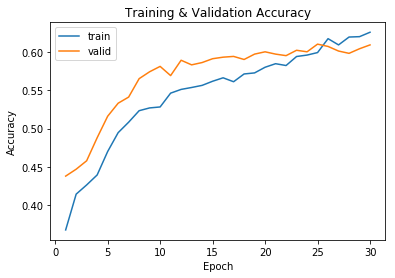

In [57]:

epochs = range(1,len(train_acc)+1)
plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, valid_acc, label="valid")
plt.title('Training & Validation Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


# 4. Test the model

In [58]:

def test_score(data, label):
    labels = []
    init_op = tf.global_variables_initializer()
    correct = 0
    
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, save_path)
        for i in range(len(data)):
            X_input = ConvertDoc2List(data[i])
            if len(X_input) < 1:
                continue
            X_input = ConvertList2Array(X_input)
            feed_dict = {document: X_input, dropout : 1.0}
            pred = sess.run(prediction, feed_dict=feed_dict)

            if np.argmax(pred) == np.argmax(label[i]):
                correct += 1
    return correct/len(data)


In [59]:

start     = time.time()
testscore = test_score(X_test, y_test)
totaltime = datetime.timedelta(seconds=round(time.time()-start))
print("\ntest accuracy: %.2f" % (testscore*100),"%")
print("Time:", totaltime)


INFO:tensorflow:Restoring parameters from /Users/apple/Desktop/Dataset/savedmodels/hmcan_small_50.ckpt

test accuracy: 61.70 %
Time: 0:00:05
